<a href="https://colab.research.google.com/github/boxed-mikann/google_colab_ipynb/blob/main/BPEexercisesA2025_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **生物工学演習A後半　第４回**

このページは生物工学演習A後半の授業資料です。閲覧・共有は受講者限りとします。

<br>

なお、「オプション」となっている項目は応用問題です。難しければ必ずしも解答する必要はありませんが、解答は加点対象になります。

<br><br>


## **課題　オープンデータを用いた脳計量**


学術研究に用いたデータは世界中の誰でもが使えるように公開することが一般的になりつつあります。このようにして公開されたデータはオープンデータと呼ばれ、様々なオープンデータをまとめたサイトが存在します。

<br>

脳・神経科学関係のデータを公開する大手サイトの一つにOpenNeuro.orgがあります。OpenNeuroでは1,400を超えるデータセット、60,000人を超える被験者のデータが公開されています（2025年7月現在）。

https://openneuro.org

<br>

今回はここに公開されているヒト超高磁場（9.4T）MRI構造画像データセットを扱います。


UltraCortex: Submillimeter Ultra-High Field 9.4T Brain MR Image Collection and Manual Cortical Segmentations

Mahler et al., (2024) *bioRxiv/OpenNeuro*

https://openneuro.org/datasets/ds005216/versions/1.0.1


<br>

上記データセットでは、0.6-0.8mm等の高いボクセル解像度で撮影されたヒト脳のT1強調画像（sub-XX/ses-1/anat/XX.nii）や、大脳皮質・白質ボクセルを抽出してその位置を示したセグメンテーションデータ（derivatives/manual_segmentation/XX.nii）、また被験者の属性情報（participants.tsv; 被験者ID、年齢、性別）などが公開されています。

<br>

1.  **上記オープンデータについて、被験者1名を下記の基準で選んだ上で、サイトのGUIを用いてT1強調画像の断面図可視化を行ってください（スクリーンショットを解答）。ただし、解答は以下の条件に沿う形で進めてください。**

  *   横断面・冠状面・矢状面それぞれに小脳が明確に含まれるようにスライスを選択してください。
  *   自分の学籍番号の下2桁と同じ、もしくはそれに最も近い被験者IDのデータについて解答してください。
  *   選んだ被験者について、被験者ID、年齢、および性別も合わせて解答してください。

2.  **手動セグメンテーション（manual segmentation）が行われている被験者のうちの任意の1名のデータについて、抽出された左右大脳皮質のボクセル位置をプロットしてください。プロットは複数スライスについて表示し、脳の形の概要が判るようにしてください。**

3.  **手動セグメンテーションが行われている被験者12名全員のデータについて、左右大脳皮質の体積（立方ミリメートル単位）を求め、12名の平均と標準偏差を解答してください。**

4.  **ヒト大脳皮質1立方ミリメートルには平均約4万個の神経細胞、および約7億個のシナプス結合(\*1)があるとされています。3.で求めた皮質体積と合わせ、ヒト大脳皮質全体にはどの程度のシナプス結合があるか概算してください。また、その数と近年の基盤モデル・大規模言語モデル（LLM）等の巨大AIモデルの結合パラメータ数（情報が公開されている中で最大級のものはLlama 4のパラメータ数2T、T=trillions）を比較し、どちらがどの程度（何倍程度）多いかを考察してください。**

5.  （オプション）**上記データのderivatives/brainmasksには小脳なども含めた脳全体（全脳）のボクセル位置を示すマスクデータが入っています。このデータと被験者情報のクロス集計を行い、性別・年齢に関する全脳体積の統計的傾向を求めてください。**


<br>

\*1: Lennie P. (2003). The cost of cortical computation. *Current Biology*, 13(6), 493–497. https://doi.org/10.1016/s0960-9822(03)00135-0

<br>

ヒント：　以下のサンプルコードや図を参照しても構いません。ただし、コードを使う場合は各行が何をしているかを理解してから利用してください。


<br>




OpenNeuroのGUIを用いたT1強調画像のスクリーンショット例：

<img src="https://nishimotolab.org/images/seeds/T1_9T_sub10.png" width=100%>



準備
```python
##　注意：以下はGoogle Colabセッション中に1回行えば環境構築とダウンロードが実行されます。セッション中に2回以上実行する必要はありません。

# GitHubを使うために必要な環境を構築
!apt-get update && apt-get install -y git-annex
!git annex init

# GitHubを介して該当するOpenNeuroデータの情報（ディレクトリ構造・ファイルリスト）を取得
# （注意: ここではファイルのリストのみが取得され、「ファイル」にそれらが表示はされますがその実体はColabサーバにダウンロードされていません）
!git clone https://github.com/OpenNeuroDatasets/ds005216.git

# derivatives/manual_segmentation内のファイルを一括ダウンロード
# （注意: この作業を行うまではファイルはColabサーバにダウンロードされていません。）
%cd /content/ds005216
!git annex get derivatives/manual_segmentation

```

<br>

データ解析を行うサンプルコード

```python
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

fname = '/content/ds005216/derivatives/manual_segmentation/sub-20_ses-1_seg.nii'

# niiファイルをロード
niidata = nib.load(fname)

# ボクセルサイズ（mm）を取得
voxel_sizes = niidata.header.get_zooms()

# Segmentationされた3次元ボリュームを取得
data = niidata.get_fdata()

## ボリューム中の要素番号と脳部位の対応
## 2   Left-Cerebral-White-Matter    左大脳白質
## 3   Left-Cerebral-Cortex          左大脳皮質（灰白質）
## 41  Right-Cerebral-White-Matter   右大脳白質
## 42  Right-Cerebral-Cortex         右大脳皮質（灰白質）

# 一部のスライスを選択して表示用の2次元行列を作成
d = data[:, :, np.linspace(0,data.shape[2]-1,8, dtype=int)]
d = d.transpose(1,2,0)
d = np.flip(d,axis=0)
d2 = np.reshape(d,[d.shape[0],d.shape[1]*d.shape[2]])

# 左大脳白質（2）と左大脳皮質(3)を選択してマスクを作成
im = (d2 == 2) | (d2 == 3)

plt.figure(figsize=(15,15))
plt.imshow(im)
plt.show()

# 左大脳白質と左大脳皮質を選択し、ボクセル数と体積を求める
count = np.count_nonzero((data == 2) | (data == 3))
volume_in_mm3 = count*np.prod(voxel_sizes)
print("Voxel count:", count)
print("Voxel size (mm):", np.round(voxel_sizes,2))
print("Volume (mm^3):", round(volume_in_mm3))
```

<br>

左右大脳皮質の想定プロット例（抜粋）

<img src="https://nishimotolab.org/images/seeds/manual_segmentation.png" width=100%>

<br><br>

その他のヒント：

多数のファイルの一括処理を行う場合、「os」ライブラリなどの機能を使ってディレクトリ中のファイル一覧をリストとして扱うと効率的です。


*   python「os」ライブラリのドキュメントや利用サンプルを確認
*   AIに「ディレクトリ（フォルダ）中のファイル一覧をリストとして取得する」等のプロンプト指定を行って得られたサンプルコードを参照


<br>



In [4]:
!curl ipinfo.io

{
  "ip": "34.150.212.215",
  "hostname": "215.212.150.34.bc.googleusercontent.com",
  "city": "Washington",
  "region": "District of Columbia",
  "country": "US",
  "loc": "38.8951,-77.0364",
  "org": "AS396982 Google LLC",
  "postal": "20004",
  "timezone": "America/New_York",
  "readme": "https://ipinfo.io/missingauth"
}

In [2]:
##　注意：以下はGoogle Colabセッション中に1回行えば環境構築とダウンロードが実行されます。セッション中に2回以上実行する必要はありません。

# GitHubを使うために必要な環境を構築
!apt-get update && apt-get install -y git-annex
!git annex init

# GitHubを介して該当するOpenNeuroデータの情報（ディレクトリ構造・ファイルリスト）を取得
# （注意: ここではファイルのリストのみが取得され、「ファイル」にそれらが表示はされますがその実体はColabサーバにダウンロードされていません）
!git clone https://github.com/OpenNeuroDatasets/ds005216.git

# derivatives/manual_segmentation内のファイルを一括ダウンロード
# （注意: この作業を行うまではファイルはColabサーバにダウンロードされていません。）
%cd /content/ds005216
!git annex get derivatives/manual_segmentation

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://cli.github.com/packages stable InRelease [3,917 B]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [6,050 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [

In [18]:
!git annex get derivatives/brainmasks/

get derivatives/brainmasks/sub-0_ses-1_brainmask.nii (from s3-PUBLIC...) 

  S3 bucket does not allow public access; Set both AWS_ACCESS_KEY_ID and AWS_SECRET_ACCESS_KEY to use S3

(checksum...) ok
get derivatives/brainmasks/sub-10_ses-1_brainmask.nii (from s3-PUBLIC...) 

  S3 bucket does not allow public access; Set both AWS_ACCESS_KEY_ID and AWS_SECRET_ACCESS_KEY to use S3

(checksum...) ok
get derivatives/brainmasks/sub-11_ses-1_brainmask.nii (from s3-PUBLIC...) 

  S3 bucket does not allow public access; Set both AWS_ACCESS_KEY_ID and AWS_SECRET_ACCESS_KEY to use S3

(checksum...) ok
get derivatives/brainmasks/sub-12_ses-1_brainmask.nii (from s3-PUBLIC...) 

  S3 bucket does not allow public access; Set both AWS_ACCESS_KEY_ID and AWS_SECRET_ACCESS_KEY to use S3

(checksum...) ok
get derivatives/brainmasks/sub-13_ses-1_brainmask.nii (from s3-PUBLIC...) 

  S3 bucket does not allow public access; Set both AWS_ACCESS_KEY_ID and AWS_SECRET_ACCESS_KEY to use S3

(checksum...) ok
get de

,participant_id,age,sex
0,sub-73,23,F
1,sub-74,33,M
2,sub-75,42,F
3,sub-70,28,F
4,sub-71,27,M
...,...,...,...
73,sub-47,37,F
74,sub-49,44,F
75,sub-50,43,M
76,sub-51,28,M


In [19]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

In [21]:
def all_brain_volume(path):#全脳の体積を返す
  niidata = nib.load(path)
  data = niidata.get_fdata()
  voxel_sizes = niidata.header.get_zooms()
  count = np.count_nonzero(data)
  volume_in_mm3 = count*np.prod(voxel_sizes)
  return volume_in_mm3

In [22]:
def cortex_volume(path):#左右大脳皮質の体積を返す
  niidata = nib.load(path)
  data = niidata.get_fdata()
  voxel_sizes = niidata.header.get_zooms()
  count = np.count_nonzero((data == 3) | (data == 42))
  volume_in_mm3 = count*np.prod(voxel_sizes)
  return volume_in_mm3

In [23]:
os.path.exists('/content/ds005216/derivatives/brainmasks/sub-0_ses-1_brainmask.nii')

True

In [25]:
import pandas as pd
import os

participants_df = pd.read_csv('/content/ds005216/participants.tsv', sep='\t')

brainmask_dir = '/content/ds005216/derivatives/brainmasks/'
brainmask_files = os.listdir(brainmask_dir)

cortex_dir = '/content/ds005216/derivatives/manual_segmentation/'
cortex_files = os.listdir(cortex_dir)

# Create a dictionary to store brain volumes
brain_volumes = {}
cortex_volumes = {}

for index, row in participants_df.iterrows():
    participant_id = row['participant_id']
    # Construct the expected filename
    brainmask_filename = f"{participant_id}_ses-1_brainmask.nii"
    brainmask_path = os.path.join(brainmask_dir, brainmask_filename)
    cortex_filename = f"{participant_id}_ses-1_seg.nii"
    cortex_path = os.path.join(cortex_dir, cortex_filename)

    # Check if the brainmask file exists
    if os.path.exists(brainmask_path):
        # Calculate brain volume using the existing function
        volume = all_brain_volume(brainmask_path)
        brain_volumes[participant_id] = volume
        print(f"Brain volume for {participant_id}: {volume} mm^3")
    else:
        print("No data:",participant_id)

    if os.path.exists(cortex_path):
        # Calculate brain volume using the existing function
        volume = cortex_volume(cortex_path)
        cortex_volumes[participant_id] = volume
        print(f"Cortex volume for {participant_id}: {volume} mm^3")
    else:
        print("No data:",participant_id)

# Convert the dictionary to a DataFrame
brain_volumes_df = pd.DataFrame.from_dict(brain_volumes, orient='index', columns=['brain_volume_mm3'])
brain_volumes_df.index.name = 'participant_id'

cortex_volumes_df = pd.DataFrame.from_dict(cortex_volumes, orient='index', columns=['cortex_volume_mm3'])
cortex_volumes_df.index.name = 'participant_id'

# Merge the brain volumes with the participants_df
participants_df = participants_df.merge(brain_volumes_df, on='participant_id', how='inner')
#participants_df = participants_df.merge(cortex_volumes_df, on='participant_id', how='inner')

display(participants_df)

Brain volume for sub-73: 1392363.0 mm^3
Cortex volume for sub-73: 474941.09375 mm^3
Brain volume for sub-74: 1601065.625 mm^3
No data: sub-74
Brain volume for sub-75: 1323627.875 mm^3
No data: sub-75
Brain volume for sub-70: 1650205.0 mm^3
Cortex volume for sub-70: 536171.5625 mm^3
Brain volume for sub-71: 1702476.375 mm^3
No data: sub-71
Brain volume for sub-68: 1551564.125 mm^3
No data: sub-68
Brain volume for sub-69: 1519752.125 mm^3
Cortex volume for sub-69: 484670.5625 mm^3
Brain volume for sub-72: 1521582.875 mm^3
No data: sub-72
Brain volume for sub-76: 1652709.75 mm^3
No data: sub-76
Brain volume for sub-77: 1633997.5 mm^3
No data: sub-77
Brain volume for sub-56: 1417322.75 mm^3
No data: sub-56
Brain volume for sub-30: 1528754.875 mm^3
No data: sub-30
Brain volume for sub-2: 1704895.0 mm^3
No data: sub-2
Brain volume for sub-5: 1600949.625 mm^3
No data: sub-5
Brain volume for sub-33: 1385481.625 mm^3
No data: sub-33
Brain volume for sub-66: 1434624.0 mm^3
No data: sub-66
Brain 

,participant_id,age,sex,brain_volume_mm3
0,sub-73,23,F,1392363.000
1,sub-74,33,M,1601065.625
2,sub-75,42,F,1323627.875
3,sub-70,28,F,1650205.000
4,sub-71,27,M,1702476.375
...,...,...,...,...
73,sub-47,37,F,1507661.500
74,sub-49,44,F,1354743.250
75,sub-50,43,M,1509419.000
76,sub-51,28,M,1823479.500


In [26]:
# Create age groups
bins = [20, 30, 40, 50, 60] # Define age bins
labels = ['20-29', '30-39', '40-49', '50-59'] # Define labels for age bins

participants_df['age_group'] = pd.cut(participants_df['age'], bins=bins, labels=labels, right=False)

# Perform cross-tabulation of average brain volume by sex and age group
cross_tab = pd.crosstab(participants_df['sex'], participants_df['age_group'], values=participants_df['brain_volume_mm3'], aggfunc='mean')

display(cross_tab)

age_group,20-29,30-39,40-49,50-59
sex,,,,
F,1438572.50,1495827.75,1373014.125,NaN
M,1625493.75,1597008.25,1590326.250,1660085.125


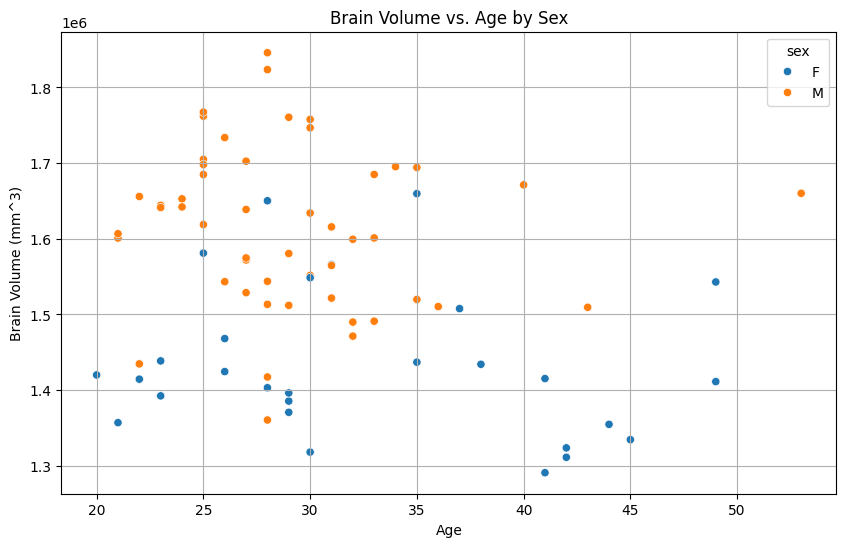

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=participants_df, x='age', y='brain_volume_mm3', hue='sex')
plt.title('Brain Volume vs. Age by Sex')
plt.xlabel('Age')
plt.ylabel('Brain Volume (mm^3)')
plt.grid(True)
plt.show()

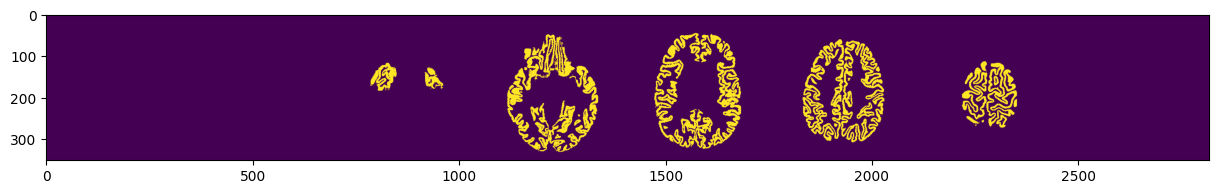

Voxel count: 2279340
Voxel size (mm): [0.6 0.6 0.6]
Volume (mm^3): 491405


In [6]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

fname = '/content/ds005216/derivatives/manual_segmentation/sub-20_ses-1_seg.nii'

# niiファイルをロード
niidata = nib.load(fname)

# ボクセルサイズ（mm）を取得
voxel_sizes = niidata.header.get_zooms()

# Segmentationされた3次元ボリュームを取得
data = niidata.get_fdata()

## ボリューム中の要素番号と脳部位の対応
## 2   Left-Cerebral-White-Matter    左大脳白質
## 3   Left-Cerebral-Cortex          左大脳皮質（灰白質）
## 41  Right-Cerebral-White-Matter   右大脳白質
## 42  Right-Cerebral-Cortex         右大脳皮質（灰白質）

# 一部のスライスを選択して表示用の2次元行列を作成
d = data[:, :, np.linspace(0,data.shape[2]-1,8, dtype=int)]
d = d.transpose(1,2,0)
d = np.flip(d,axis=0)
d2 = np.reshape(d,[d.shape[0],d.shape[1]*d.shape[2]])

# 左大脳白質（2）と左大脳皮質(3)を選択してマスクを作成
im = (d2 == 42) | (d2 == 3)

plt.figure(figsize=(15,15))
plt.imshow(im)
plt.show()

# 左大脳白質と左大脳皮質を選択し、ボクセル数と体積を求める
count = np.count_nonzero((data == 42) | (data == 3))
volume_in_mm3 = count*np.prod(voxel_sizes)
print("Voxel count:", count)
print("Voxel size (mm):", np.round(voxel_sizes,2))
print("Volume (mm^3):", round(volume_in_mm3))